In [56]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


# Глобальные параметры
ONE_CYLINDRE_COST_USD = 13000  # 10000 цена одного вала в долларах
CYLINDRE_WIDTH = 0.45  # 0.24 ширина вала в м

ONE_ZUB_mm = 3.175  # шаг, с кторым меняется длина окружности вала в миллиметрах
M_range = range(76, 190)  # Диапазон значений для M (доступные размеры валов)
AMORT_COST_PER_METER = 0.18  # 1.8 амортизация и издержки в ДОЛЛАРАХ за один метр прогона
TECH_LOSS = 72  # 60 технические потери бумаги метры пробега
PAPER_PRICE_RUB = 72  # ценя в рублях за квадратный метр бумаги по курсу 90
AMORT_YEARS = 5  # период амортизации валов
SLED_SIZE_mm = 7.5 # ширина лыж
N_vals = 5 # кол-во валов


MAX_JAMBO_ROLL_WIDTH_m = 1.53  # Максимальная ширина джамбороля в метрах
JAMBO_ROLL_LENGTH_m = 6000  # Длина джамбороля в метрах
MAX_KNIFES_ON_ROLL = 10  # максимальное кол-во ножей на станке, режущем роль
MIN_ROLLIC_LENGTH_m = 100  # минимальная длина ролика в метрах
MAX_ROLLIC_LENGTH_m = 2000  # максимальная длина ролика в метрах

# Стоимость материалов
material_costs = {'пленка': 0.63, 'полуглянец': 0.44, 'термочек': 0.56}

# Параметры для 'mer' (межэтикеточное расстояние) в зависимости от материала
mer_values = {'пленка': 3, 'термочек': 3, 'default': 5}  # Значение по умолчанию для других материалов


def params():
    """
    Функция выводит все важные параметры системы.
    """
    print("Переменные параметры:")
    print("Цена одного вала в долларах - ", ONE_CYLINDRE_COST_USD)
    print("Ширина вала в метрах - ", CYLINDRE_WIDTH)
    print("Шаг, с которым меняется длина окружности вала в миллиметрах - ", ONE_ZUB_mm)
    print("Доступные диапазоны окружности вала - ", M_range)
    print("Амортизация и издержки в рублях за один метр прогона - ", AMORT_COST_PER_METER)
    print("Технические потери бумаги, метры пробега - ", TECH_LOSS)
    print("Цена бумаги за квадратный метр (руб) - ", PAPER_PRICE_RUB)
    print("Максимальная ширина джамбороля в метрах - ", MAX_JAMBO_ROLL_WIDTH_m)
    print("Длина джамбороля в метрах - ", JAMBO_ROLL_LENGTH_m)
    print("Максимальное количество ножей на станке - ", MAX_KNIFES_ON_ROLL)
    print("Минимальная длина ролика в метрах - ", MIN_ROLLIC_LENGTH_m)
    print("Максимальная длина ролика в метрах - ", MAX_ROLLIC_LENGTH_m)

    
def fn(M, s1n, mer):
    """
    Вычисления в миллиметрах!
    
    Функция определяет количество этикеток шириной `s1n` и межручьевое расстояние `mer`,
    которые могут уместиться на валу, длина окружности которого определяется 
    как M * ONE_ZUB_mm (где M - количество зубьев вала).
    
    Параметры:
    M    : int  - количество зубьев на валу (определяет длину окружности вала)
    s1n  : int  - ширина этикетки в миллиметрах
    mer  : int  - межэтикеточное расстояние (МЭР) в миллиметрах
    
    Возвращает:
    int  - количество этикеток, которые могут уместиться на валу
    """
    i = 0
    # было 31.11.2024 while (i * (s1n + mer) + mer) <= ONE_ZUB_mm * M:#
    while (i * (s1n + mer)) <= ONE_ZUB_mm * M:
        i += 1
    return i - 1


# Тестирование функции
assert fn(M=185, s1n=70, mer=3) == 8
assert fn(M=164, s1n=100, mer=3) == 5
assert fn(M=187, s1n=95, mer=3) == 6



def fm(s2n, mer, roll_width=CYLINDRE_WIDTH * 1000):
    """
    Вычисления в миллиметрах!
    Ф-ция определяет кол-во этикеток шириной = S2n и МЭР=mer, 
    которые уместятся на валу шириной roll_width.
    
    Параметры:
    s2n : int  - ширина этикетки в миллиметрах
    mer : int  - межручьевое расстояние (МЭР) в миллиметрах
    roll_width : int - ширина вала в миллиметрах (по умолчанию 450 мм = 0.45 м)
    """
    assert roll_width <= 450, 'ширина вала не может быть больше 45 см'
    i = 0
    while (i * (s2n + mer) - mer) + SLED_SIZE_mm*2 <= roll_width:  #SLED_SIZE_mm
        i += 1
    return i - 1


# Тестирование
assert fm(s2n=70, mer=3) == 6  # Ширина вала берется по умолчанию из параметра CYLINDRE_WIDTH

print()

In [57]:
# Загрузка данных
idf = pd.read_excel("label_cleaned_21_24_no_customer_20240910.xlsx", engine='openpyxl')

# Добавляем колонку "mer" в зависимости от значения "Material", используя параметры
idf['mer'] = idf.Material.apply(lambda x: mer_values.get(x, mer_values['default']))
idf = idf[idf.Report_Unit_Thousands > 0]
idf.reset_index(drop=True, inplace=True)
expected_columns = ['Month', 'SKU', 'Product', 'Report_Unit_Thousands', 'Km',
       'L dimension (mm)', 'Cylinder number', 'label spacing v',
       'label spacing h', 'Gross_Sales', 'Type_of_Label', 'Size1', 'Size2',
       'Material', 'Embossing', 'Color', 'Glue_Type', 'mer']
idf = idf[idf[['Size2','Size1','Report_Unit_Thousands','label spacing h', 'label spacing v','Material']].notna().T.all()]

In [58]:
sorted(set(idf.Month))

['Август 2021 г.',
 'Август 2022 г.',
 'Август 2023 г.',
 'Август 2024 г.',
 'Апрель 2022 г.',
 'Апрель 2023 г.',
 'Апрель 2024 г.',
 'Декабрь 2021 г.',
 'Декабрь 2022 г.',
 'Декабрь 2023 г.',
 'Июль 2022 г.',
 'Июль 2023 г.',
 'Июль 2024 г.',
 'Июнь 2022 г.',
 'Июнь 2023 г.',
 'Июнь 2024 г.',
 'Май 2022 г.',
 'Май 2023 г.',
 'Май 2024 г.',
 'Март 2022 г.',
 'Март 2023 г.',
 'Март 2024 г.',
 'Ноябрь 2021 г.',
 'Ноябрь 2022 г.',
 'Ноябрь 2023 г.',
 'Октябрь 2021 г.',
 'Октябрь 2022 г.',
 'Октябрь 2023 г.',
 'Сентябрь 2021 г.',
 'Сентябрь 2022 г.',
 'Сентябрь 2023 г.',
 'Февраль 2022 г.',
 'Февраль 2023 г.',
 'Февраль 2024 г.',
 'Январь 2022 г.',
 'Январь 2023 г.',
 'Январь 2024 г.']

#### Выберите один из периодов из списка выше и вставьте в строку ввода ниже
#### Либо укажите год
#### Если хотите вести анализ по всем данным, а не по кнкретному периоду, оставьте поле пустым

In [59]:
period = input()
if period:
    if period.isdigit():
        idf = idf[idf.Month.apply(lambda x: period in x)].reset_index()[expected_columns]
    else:
        idf = idf[idf.Month == period].reset_index()[expected_columns]
    

In [60]:
idf.head()

,Month,SKU,Product,Report_Unit_Thousands,Km,L dimension (mm),Cylinder number,label spacing v,label spacing h,Gross_Sales,Type_of_Label,Size1,Size2,Material,Embossing,Color,Glue_Type,mer
0,Январь 2023 г.,"Термочек 70*95, каучук.",Термопустышка 5000138,2033.640,68.890,95.0,96,3.0,6.600,2493869.77,Термочек,70.0,95.0,термочек,NaN,NaN,каучуковый,3
1,Январь 2023 г.,"Термочек 70*95, каучук.",Термопустышка 5002950,1028.385,34.837,95.0,96,3.0,6.600,1264338.73,Термочек,70.0,95.0,термочек,NaN,NaN,каучуковый,3
2,Январь 2023 г.,"Термочек 70*95, каучук.",Термочек универсальный для ОПФ 5002559,28.095,0.952,95.0,96,3.0,6.600,34742.89,Термочек,70.0,95.0,термочек,NaN,NaN,каучуковый,3
3,Январь 2023 г.,"Термочек 70*95, каучук.",Фарш универсальный 5002499,328.880,12.534,70.0,96,3.0,6.200,402827.58,Термочек,70.0,95.0,термочек,NaN,NaN,каучуковый,3
4,Январь 2023 г.,"Этикетка 100*100 пленка, белая, акр.",Докторская ГОСТ 1000 гр 5002996,48.230,2.578,100.0,101,5.0,6.892,86752.27,Этикетка,100.0,100.0,пленка,NaN,белая,акриловый,3


In [61]:
res = []
for _, row in idf.iterrows():
    l = row['L dimension (mm)']
    s1 = row['Size1']
    s2 = row['Size2']
    if l == s1:
        res.append(0)
    elif l == s2:
        res.append(1)
    else:
        res.append(-1)
idf['reverse'] = pd.Series(res)
idf_rev = idf[idf['reverse'] == 1]
idf_nrev = idf[idf['reverse'] == 0]
idf_rev.columns = ['Month', 'SKU', 'Product', 'Report_Unit_Thousands', 'Km',
       'L dimension (mm)', 'Cylinder number', 'label spacing h',
       'label spacing v', 'Gross_Sales', 'Type_of_Label', 'Size2', 'Size1',
       'Material', 'Embossing', 'Color', 'Glue_Type', 'mer', 'reverse']
idf = pd.concat([idf_rev, idf_nrev], axis=0)
idf = idf[expected_columns]

# 1)Необходимо вычислить разницу фактических потерь по каждой этикетке с потерями после оптимизации по валам.
#### Какие параметры оптимизируем: а) номер вала, б) расположение этикетки на валу
#### Какую величину мы оптимизируем: стоимость обрезков 

<img src="photos/1.png" />
<img src="photos/2.jpeg" />
<img src="photos/3.jpeg" />



<dt>Определим формулу потерь Loss_i для i-того заказа</dt>
<dd> - потери выражаются в долларах </dd>
<dd> - миллиметры приводим в метры </dd>

$$
Loss_i = S_i * price_i = n_i * h_i * L_i * price_i = 
\overbrace{
[\underbrace{\frac{RUT  * 10^{3}}{fm}}_\text{кол-во этикеток в одном ручье}
* lsh}
^\text{высота всех отступов в ручье}
 * 
\underbrace{(lsv * (fm-1) + 2 ssd)}_\text{ширина всех отступов в ряду}
* price * 10^{-6} ]_i 
$$

<dt>Где</dt>
<dd>- lsh (дано) - lable spacing h</dd>
<dd>- lsv (дано) - lable spacing v</dd>
<dd>- ssd (дано) - SLED_SIZE_mm</dd>
<dd>- RUT (дано) - Report_Unit_Thousands</dd>
<dd>- fm (вычисляем) - Ф-ция определяет кол-во этикеток шириной = S2n и МЭР=mer, 
    которые уместятся на валу шириной roll_width.</dd>
<dd>- price (вычисляем) - цена кв. метра марериала</dd>

In [62]:
def Loss_i(lsh, lsv, RUT, price, s2n, mer=None):
    this_fm = fm(s2n, mer) if mer else fm(s2n, lsv) #roll_width
    return (lsh * RUT * (lsv * (this_fm-1) + 2 * SLED_SIZE_mm) *  price) / (this_fm * 1000)

#### Потери в долларах без учета тех. потерь и с фактическими отступами

In [63]:
idf.apply(lambda x: Loss_i(lsh=x['label spacing h'], lsv=x['label spacing v'],
                           RUT=x['Report_Unit_Thousands'], price=material_costs[x['Material']],
                           s2n=x['Size2']), axis=1).sum()

1793.6892812404071

#### Потери в долларах без учета тех. потерь с отступами = mer

In [64]:
idf.apply(lambda x: Loss_i(lsh=x['mer'], lsv=x['mer'],
                           RUT=x['Report_Unit_Thousands'], price=material_costs[x['Material']],
                           s2n=x['Size2']), axis=1).sum()

848.9328072915076

<dt> Уточним формулу потерь Loss_i для i-того заказа с учетом тех. потерь</dt>

$$
LossTL_i =  \underbrace{TL}_\textrm{длина пробега тех.потерь}* 
\underbrace{[fm * (S_2 + lsv)  - lsv + 2 ssd)] * price * 10^-3}_\textrm{ширина печати}$$

<dt>Где</dt>
<dd>- ssd (дано) - SLED_SIZE_mm</dd>
<dd>- lsv (дано) - lable spacing v</dd>
<dd>- TL (дано) TECH_LOSS = 60  # 15.6 технические потери бумаги метры пробега</dd>
<dd>- fm (вычисляем) - Ф-ция определяет кол-во этикеток шириной = S2n и МЭР=mer, 
    которые уместятся на валу шириной roll_width.</dd>
<dd>- S_2 (дано) - ширина этикетки</dd>

In [65]:
def LossTL_i(lsv, price, s2n, mer=None):
    this_fm = fm(s2n, mer) if mer else fm(s2n, lsv) #roll_width
    this_cylinder_width = (this_fm * (s2n + lsv) - lsv + 2 * SLED_SIZE_mm) *  price / 1000
    assert this_cylinder_width <= CYLINDRE_WIDTH
    return TECH_LOSS * this_cylinder_width # переводим миллиметры в метры

#### Потери в долларах с учетом тех. потерь и с фактическими отступами

In [66]:
idf.apply(lambda x: LossTL_i(lsv=x['label spacing v'],
                           price=material_costs[x['Material']],
                           s2n=x['Size2']), axis=1).sum()

65509.594250400005

<dt> Таким образом, суммарные потери состоят из 1) фиксированных тех. потерь на МЭР 2) тех. потерь на холостой пробег вала и 3) из потерь из-за разницы фактического МЭР и нормативного</dt>
<dd> третью составляющую потерь можно оптимизировать подбором наимболее оптимального номера вала для каждой этикетки</dd>

$$
SummLoss_i = 
\underbrace{Loss(mer_i)}_\textrm{фиксированных тех. потерь на МЭР} +
\underbrace{LossTL_i(TL)}_\textrm{тех. потерь на холостой пробег вала} +
\underbrace{LossOpt(M_i)}_\textrm{потери из-за разницы фактического МЭР и нормативного}
$$

$$
mer_i = const \Rightarrow  Loss(mer_i) = const
$$

$$
TL = const \Rightarrow LossTL_i(TL) = const
$$

$$
M \in[76, 190]
$$
<dd>Т.о. ф-ция оптимизации будет выглядеть, как</dd>
$$
M_{opt} = \min_{M}{LossOpt(M)}
$$

<dt>Где</dt>
<dd>- M - номер вала</dd>

In [67]:
def SummLoss_i(lsh, lsv, RUT, price, s2n, mer=None):
    li = Loss_i(lsh, lsv, RUT, price, s2n, mer)
    tli = LossTL_i(lsv, price, s2n, mer)
    return li + tli

In [68]:
idf.apply(lambda x: SummLoss_i(lsh=x['label spacing h'], lsv=x['label spacing v'],
                           RUT=x['Report_Unit_Thousands'], price=material_costs[x['Material']],
                           s2n=x['Size2']), axis=1).sum()

67303.2835316404

$$
LossOpt(M_i) = SummLoss_i - LossTL_i(TL) - LossOpt(M_i)
$$

<dt> Теперь будем оптимизировать номер вала M</dt>
<dd> при этом lsh - отступ поперек вала станет переменным</dd>


$$
lsh = f(M) = M * oz -  fn(M) * (S_1 + mer)
$$

<dt>Где</dt>
<dd>- oz (дано) - ONE_ZUB_mm</dd>
<dd>- S_1 (дано) - высота этикетки</dd>
<dd>- fn (выч. целое) - Функция определяет количество этикеток шириной `s1n` и межручьевое расстояние `mer`,
    которые могут уместиться на валу, длина окружности которого определяется 
    как M * ONE_ZUB_mm (где M - количество зубьев вала).</dd>


In [69]:
def lsh(s1n, mer, M):
    return M * ONE_ZUB_mm - fn(M, s1n, mer) * (s1n + mer)

<dd> С учетом фармулы для lsh уточним расчет LossOpt_i</dd>

In [70]:
def LossOpt_i(M, lsv, RUT, price, s1n, s2n, mer):
    this_lsh = lsh(s1n, mer, M)
    Loss_i_mer = Loss_i(lsh=mer, lsv=mer, RUT=RUT, price=price, s2n=s2n)
    Loss_i_real = Loss_i(lsh=this_lsh, lsv=lsv, RUT=RUT, price=price, s2n=s2n)
    return Loss_i_real - Loss_i_mer

<dt> Ниже текущие потери БЕЗ ОПТИМИЗАЦИИ</dt>
<dd> Нужно улучшить это значение </dd>

In [71]:
((idf['Size1'] + idf['label spacing h']) * (idf['Size2'] +
                                            idf['label spacing v']) * idf['Report_Unit_Thousands'] * 1000).sum() / 1000000

630458.0790634673

In [72]:
((idf['label spacing h'] - idf.mer) * (idf['label spacing v'] 
                                       - idf.mer) * idf['Report_Unit_Thousands'] * 1000).sum() / 1000000

331.15817745436

In [73]:
print("Текущий набор валов: " ,sorted(set(idf['Cylinder number'])))
print("Текущие потери: ")
print(int(idf.apply(lambda x: LossOpt_i(mer=x['mer'], M=x['Cylinder number']
                             , lsv=x['label spacing v'],
                           RUT=x['Report_Unit_Thousands'], price=material_costs[x['Material']],
                           s1n=x['Size1'], s2n=x['Size2']), axis=1).sum()), '$')

Текущий набор валов:  [64, 79, 96, 101, 104, 110, 121]
Текущие потери: 
5759 $


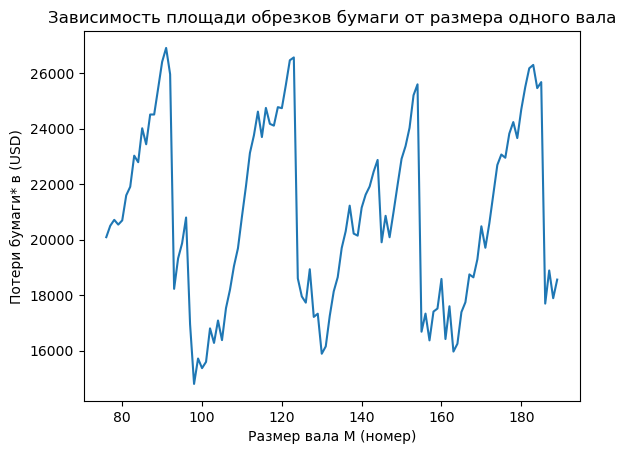

In [74]:
res = []
for M in M_range:
    lossm = idf.apply(lambda x: LossOpt_i(mer=x['mer'], M=M
                             , lsv=x['label spacing v'],
                           RUT=x['Report_Unit_Thousands'], price=material_costs[x['Material']],
                           s1n=x['Size1'], s2n=x['Size2']), axis=1).sum()
    res.append([M, lossm])

plt.xlabel('Размер вала M (номер)')
plt.ylabel('Потери бумаги* в (USD)') # * учитывается различная стоимость бумаги, термочека и пленки
plt.title('Зависимость площади обрезков бумаги от размера одного вала')
plt.plot([e[0] for e in res],
        [e[1] for e in res])
plt.show()

In [75]:
best_vals = sorted(res, key=lambda x: x[1])
best_val = best_vals[0][0]
best_loss = best_vals[0][1]
pd.DataFrame(best_vals[:3], columns=['M','Loss'])

,M,Loss
0,98,14798.361384
1,100,15366.882491
2,101,15592.510496


In [76]:
print("При выборе одного вала на все заказы, таким валом будет: " , best_val)
print("Для него потери: ", int(best_loss))

При выборе одного вала на все заказы, таким валом будет:  98
Для него потери:  14798


## Множественная оптимизация валов
<dt>До этого мы выбирали один размер вала, который будет подхотьб лучше всего. А теперь будем выбирать наборы валов количеством от 1 до N_vals, так чтобы потрети были минимальны</dt>

<dt> На результат множественной оптимизации вслияет способ выбора групп заказов. Для каждой из групп выбирается оптимальный вал. Варианты выбора групп: </dt>

<dd>0. По паретто </dd>
<dd>1. Группы заказов с одинаковым Cylinder number </dd>
<dd>2. Группы заказов с одинаковым Size1 </dd>
<dd>3. Группы заказов с одинаковым Size1 и Size2 </dd>
<dd>4. Рандомно </dd>


In [77]:
def evaluate_by_group(group_name):
    loss_for_group = []

    for lg in sorted(set(idf[group_name])):
        this_group_df = idf[idf[group_name] == lg]
        res = []
        for M in M_range:
            lossm = this_group_df.apply(lambda x: LossOpt_i(mer=x['mer'], M=M
                                     , lsv=x['label spacing v'],
                                   RUT=x['Report_Unit_Thousands'], price=material_costs[x['Material']],
                                   s1n=x['Size1'], s2n=x['Size2']), axis=1).sum()

            res.append([M, lossm])
        best_val = sorted(res, key=lambda x: x[1])[0][0]
        best_val_loss = sorted(res, key=lambda x: x[1])[0][1]
        loss_for_group.append([lg, best_val, best_val_loss, res])
    this_loss = sum([e[2] for e in loss_for_group])
    this_loss_dict = {e[0]: e[1] for e in loss_for_group}
    return this_loss, this_loss_dict

<dd>2. Группы заказов с одинаковым Size1 </dd>

In [78]:
agg_idf = idf.groupby(["Size1",'mer']).sum()['Gross_Sales'].sort_values(ascending=False)
ddf = pd.DataFrame([agg_idf, agg_idf.cumsum() / agg_idf.sum()]).T
ddf.columns = ['Gross_Sales','CSP']

def get_group_of_lable(s1n, mer, N=N_vals):
    csp = ddf.loc[(s1n, mer)]['CSP']
    prev_delim = 0
    for delim in list(np.arange(0, 1, 1 / N))[1:] + [1]:
        if prev_delim <= csp < delim:
            return delim
        else:
            prev_delim = delim
    return 

idf['lable_group'] = idf.apply(lambda x: get_group_of_lable(s1n=x['Size1'],
                                                            mer=x['mer'], N=N_vals) or 1, axis=1)
ddf.head()

,,Gross_Sales,CSP
Size1,mer,,
95.0,3,23228271.70,0.185678
100.0,3,11115123.63,0.274529
70.0,3,9669751.68,0.351825
150.0,3,7294859.85,0.410138
90.0,3,5335020.31,0.452784


In [79]:
this_loss, this_loss_dict =  evaluate_by_group('lable_group')
idf['rec_cyl_s1g'] = idf['lable_group'].apply(lambda x: this_loss_dict[x])

print(int(this_loss))

9264


<dd>3. Группы заказов с одинаковым Size1 и Size2 </dd>

In [80]:
agg_idf = idf.groupby(["Size1",'mer', 'Size2']).sum()['Gross_Sales'].sort_values(ascending=False)
ddf = pd.DataFrame([agg_idf, agg_idf.cumsum() / agg_idf.sum()]).T
ddf.columns = ['Gross_Sales','CSP']
ddf.head()

def get_group_of_lable(s1n, s2n, mer, N=N_vals):
    csp = ddf.loc[(s1n, mer, s2n)]['CSP']
    prev_delim = 0
    for delim in list(np.arange(0, 1, 1 / N))[1:] + [1]:
        if prev_delim <= csp < delim:
            return delim
        else:
            prev_delim = delim
    return 

idf['lable_group_s12'] = idf.apply(lambda x: get_group_of_lable(s1n=x['Size1'], s2n=x['Size2'],
                                                                mer=x['mer'], N=N_vals) or 1, axis=1)    

In [81]:
this_loss, this_loss_dict =  evaluate_by_group('lable_group_s12')
idf['rec_cyl_s12g'] = idf['lable_group_s12'].apply(lambda x: this_loss_dict[x])

print(int(this_loss))

9986


<dd>1. Группы заказов с одинаковым Cylinder number </dd>

In [82]:
this_loss, this_loss_dict =  evaluate_by_group('Cylinder number')
idf['rec_cyl_cylg'] = idf['Cylinder number'].apply(lambda x: this_loss_dict[x])

print(int(this_loss))

5248


In [83]:
print("Рекомендуемый набор валов: " ,sorted(set(idf['rec_cyl_s12g'])))
print("потери: ", (int(this_loss)))

Рекомендуемый набор валов:  [79, 93, 98, 163, 171]
потери:  5248


In [84]:
print("Текущий набор валов: " ,sorted(set(idf['Cylinder number'])))
print("Текущие потери: ")
print(int(idf.apply(lambda x: LossOpt_i(mer=x['mer'], M=x['Cylinder number']
                             , lsv=x['label spacing v'],
                           RUT=x['Report_Unit_Thousands'], price=material_costs[x['Material']],
                           s1n=x['Size1'], s2n=x['Size2']), axis=1).sum()), '$')

Текущий набор валов:  [64, 79, 96, 101, 104, 110, 121]
Текущие потери: 
5759 $


<dd>4. Рандомно </dd>

In [85]:
idf['lable_group_rand'] =  idf.apply(lambda x: np.random.randint(N_vals), axis=1)

In [86]:
this_loss, this_loss_dict =  evaluate_by_group('lable_group_rand')
idf['rec_cyl_rand'] = idf['lable_group_rand'].apply(lambda x: this_loss_dict[x])

print(int(this_loss))

14682


# Оптимизация количества ручьев

In [87]:
idf[['Report_Unit_Thousands','Km','L dimension (mm)','Cylinder number',
     'label spacing v','Size1', 'Size2', 'mer']].head()

,Report_Unit_Thousands,Km,L dimension (mm),Cylinder number,label spacing v,Size1,Size2,mer
0,2033.640,68.890,95.0,96,6.6,95.0,70.0,3
1,1028.385,34.837,95.0,96,6.6,95.0,70.0,3
2,28.095,0.952,95.0,96,6.6,95.0,70.0,3
13,28.410,0.962,95.0,96,6.6,95.0,70.0,3
14,27.360,0.927,95.0,96,6.6,95.0,70.0,3


In [88]:
def get_range_of_k(lable_width, mer):
    """
    Функция определяет допустимое кол-во ручьев на валу шириной CYLINDRE_WIDTH
    в зависимости от ширины этикетки lable_width и МЭР mer
    Все измерения в метрах!
    """
    good_ks = []
    k = 1
    while k * (lable_width + mer) - mer + 2 * SLED_SIZE_mm * 0.001 < CYLINDRE_WIDTH:  # 12.04 было k * (lable_width + mer) + mer
        good_ks.append(k)
        k += 1
    return good_ks
assert get_range_of_k(0.095, 0.003) == [1, 2, 3, 4]

In [89]:
def Loss_4K(lable_hights, lable_width, mer, pcs, this_k, material):
    """
    Функция считае потери в рублях за печать pcs штук этикеток
    размером hights на width в this_k ручья
    material_costs
    AMORT_COST_PER_METER
    TECH_LOSS
    """
    this_loss = (AMORT_COST_PER_METER * (lable_hights + mer) * pcs)  / this_k + \
                ((lable_width + mer) * this_k - mer  + 2 * SLED_SIZE_mm * 0.001)* \
                material_costs[material]  * TECH_LOSS# Цена метра квадратного бумаги в долларах
    return this_loss

In [90]:
res = []
for _, row in idf.iterrows():
    lable_hights = row.Size1 / 1000 # длина
    lable_width = row.Size2 / 1000# ширина
    this_material = row['Material']
    mer = row.mer / 1000
    pcs = row['Report_Unit_Thousands'] * 1000
    ks = get_range_of_k(lable_width, mer)
    losses = []
    for k in ks:
        this_loss = Loss_4K(lable_hights, lable_width, mer, pcs, k, this_material)
        losses.append([k, this_loss])

    if losses: 
        k_optim = sorted(losses, key = lambda x: int(x[1]))[0][0]
        k_max = max([e[0] for e in losses])
        res.append([k_optim, k_max])
    else:
        res.append([0,0])
    
idf.reset_index(drop=True, inplace=True)
idf['k_optim'] = pd.Series([e[0] for e in res])
idf['k_max'] = pd.Series([e[1] for e in res])

In [91]:
idf[['Report_Unit_Thousands','Km','L dimension (mm)','Cylinder number',
     'label spacing v','Size1', 'Size2', 'mer', 'k_optim', 'k_max']][idf.k_optim != idf.k_max ]

,Report_Unit_Thousands,Km,L dimension (mm),Cylinder number,label spacing v,Size1,Size2,mer,k_optim,k_max
33,4.300,0.413,180.0,121,12.088,180.0,45.0,3,8,9
34,4.720,0.454,180.0,121,12.088,180.0,45.0,3,7,9
46,12.720,0.453,100.0,101,6.892,100.0,33.0,3,11,12
47,8.480,0.453,100.0,101,6.891,100.0,50.0,3,7,8
48,8.840,0.472,100.0,101,6.891,100.0,50.0,3,7,8
...,...,...,...,...,...,...,...,...,...,...
3881,5.420,0.453,80.0,79,5.000,80.0,80.0,3,4,5
3883,5.055,0.423,80.0,79,5.000,80.0,80.0,3,4,5
3884,5.315,0.444,80.0,79,5.000,80.0,80.0,3,4,5
3887,5.310,0.444,80.0,79,5.000,80.0,80.0,3,4,5


In [92]:
(idf.k_max - idf.k_optim ).sum()

800

#  Джамбо ролли

#### Для каждого заказа выберем максимальное кол-во ручьев k_optim и соответственную ширину печати paint_width_m

In [93]:
idf.head()

,Month,SKU,Product,Report_Unit_Thousands,Km,L dimension (mm),Cylinder number,label spacing v,label spacing h,Gross_Sales,...,mer,lable_group,rec_cyl_s1g,lable_group_s12,rec_cyl_s12g,rec_cyl_cylg,lable_group_rand,rec_cyl_rand,k_optim,k_max
0,Январь 2023 г.,"Термочек 70*95, каучук.",Термопустышка 5000138,2033.640,68.890,95.0,96,6.6,3.0,2493869.77,...,3,0.2,93,0.2,93,93,0,98,5,5
1,Январь 2023 г.,"Термочек 70*95, каучук.",Термопустышка 5002950,1028.385,34.837,95.0,96,6.6,3.0,1264338.73,...,3,0.2,93,0.2,93,93,4,98,5,5
2,Январь 2023 г.,"Термочек 70*95, каучук.",Термочек универсальный для ОПФ 5002559,28.095,0.952,95.0,96,6.6,3.0,34742.89,...,3,0.2,93,0.2,93,93,4,98,5,5
3,Январь 2023 г.,"Этикетка 70*95 пленка, белая, акр.",Бекон Европейский 150 гр 5001210,28.410,0.962,95.0,96,6.6,3.0,34846.37,...,3,0.2,93,0.2,93,93,1,98,5,5
4,Январь 2023 г.,"Этикетка 70*95 пленка, белая, акр.",Боярская 400 гр._Дюжий двор 5002392,27.360,0.927,95.0,96,6.6,3.0,33511.81,...,3,0.2,93,0.2,93,93,4,98,5,5


In [94]:
idf['optim_cylindre']  = idf['rec_cyl_cylg']

In [95]:

idf['paint_width_mm'] = idf.apply(lambda x: ((x['Size2'] + x['mer']) * x['k_optim']) - x['mer'] + 2*SLED_SIZE_mm,
          axis=1)

In [96]:
def one_roll_loss(M, this_s1, this_s2, this_mer, num_lables, this_fn=None, this_fm=None):
    """
        функия возвращает потери в рублях за прогон одного ролля 
        M - кол-во "зубцов" вала
        ---- roll_width - ширина одного роля <= 0.45
        ---- roll_length - длина одного ролля
        this_s1 - высота этикетки
        this_s2 - ширина этикетки
        this_mer - МЭР для этикетки
        num_lables - кол-во этикеток
        reverse - если True, то this_s1 и this_s2 меняются местами
        
        returns (loss_m2, loss_rub, roll_width, roll_length) 
    """
    # посчитаем длину ширину одного ПРИНТА (то, что отпечатывает один вал за один раз)
    if not this_fm:
        this_fm = fm(roll_width=450, s2n=this_s2, mer=this_mer) # кол-во этикеток, кот. поместится на роллик по ширин, вдоль вала
    
    print_width_m = ((this_s2 + this_mer) * this_fm - this_mer + 2 * SLED_SIZE_mm * 0.001 ) / 1000
    if not this_fn:
        this_fn = fn(M=M, s1n=this_s1, mer=this_mer) # кол-во этикеток, кот. поместится на роллик по длине поперек вала
    print_higth_m = ((this_s1 + this_mer) * this_fn )/ 1000 # было +  this_mer

    
    # посчитаем потери вдоль и поперек вала на один ПРИНТ
    val_hights_m = ONE_ZUB_mm * M / 1000
    loss_hights_m = val_hights_m - print_higth_m

    # посчитаем кол-во этикеток на одном ПРИНТЕ
    num_lables_one_print = this_fm * this_fn
    if num_lables_one_print == 0 : 
        num_lables_one_print = 1
        print(M, this_s1, this_s2, this_mer, num_lables)
        print(this_fn, this_fm)

    # чтобы напечатать num_lables этикеток, нужно сделать num_prints принтов
    num_prints = np.ceil(num_lables / num_lables_one_print)
    total_print_hights_m = print_higth_m * num_prints
    loss_m2 =  print_width_m * loss_hights_m * num_prints

    return [loss_m2, loss_m2 * PAPER_PRICE_RUB, print_width_m, total_print_hights_m, val_hights_m, num_prints]

one_roll_loss(M=185, this_s1=70, this_s2=95, this_mer=3, num_lables=1096655 ,this_fm = 6)

[45.10970225437522, 3247.898562315016, 0.585015, 13342.648, 0.587375, 22847.0]

In [97]:
losses_list = [one_roll_loss(M=r.optim_cylindre, this_s1=r.Size1, this_s2=r.Size2, this_mer=r.mer, 
               num_lables=r.Report_Unit_Thousands * 1000, this_fm=r.k_optim
                ) for _, r in idf.iterrows()]
idf.reset_index(drop=True, inplace=True)
idf['loss_m2'] = [e[0] for e in losses_list]
idf['loss_rub'] = [e[1] for e in losses_list]
idf['roll_width'] = [e[2] for e in losses_list]
idf['roll_length'] = [e[3] for e in losses_list]
idf['val_hights_m'] = [e[4] for e in losses_list]
idf['num_prints'] = [e[5] for e in losses_list]

idf['order_id'] = idf.index

93 295.0 75.0 3 21200.0
0 5
93 295.0 75.0 3 23850.0
0 5


## Best Fit Decreasing High
https://habr.com/ru/articles/136225/

In [98]:
assert fn(M=187, s1n=95, mer=3) == 6
idf['num_etiket_on_cylindre'] =  idf.apply(lambda x: fn(x['optim_cylindre'], x['Size1'], x['mer']), axis=1)
rolls = []
for i, order in idf.iterrows(): #  итерируемся по заказам
    roll_width = order.roll_width
    roll_length = order.roll_length
    order_id = order.order_id
    optim_cylindre = order.optim_cylindre

    if roll_length > MAX_ROLLIC_LENGTH_m:
        for sub_roll in range(int(roll_length // MAX_ROLLIC_LENGTH_m)):
            rolls.append([roll_width, MAX_ROLLIC_LENGTH_m, order_id, optim_cylindre])
        rolls.append([roll_width, roll_length % MAX_ROLLIC_LENGTH_m, order_id, optim_cylindre])
    else:
        rolls.append([roll_width, roll_length, order_id, optim_cylindre])
        
        
        
layers = []
this_layer = {
    "lables": [], # len() < MAX_KNIFES_ON_ROLL
    "max_hights": 0, # <= MAX_ROLLIC_LENGTH_m
    "max_width": 0, # <= MAX_JAMBO_ROLL_WIDTH_m
    "id": None,
}
i = 0
for _, row in pd.DataFrame(rolls, columns=[
    "roll_width","roll_length", "order_id", "optim_cylindre"]).sort_values([
    "roll_length","roll_width"], ascending=False).iterrows():
    roll_length = row.roll_length
    roll_width = row.roll_width
    order_id = row.order_id
    
    if len(this_layer['lables']) + 1 > MAX_KNIFES_ON_ROLL \
        or this_layer['max_width'] + roll_width > MAX_JAMBO_ROLL_WIDTH_m :
        this_layer['id'] = 1
        layers.append(this_layer)
        this_layer = { "lables": [], "max_hights": 0,"max_width": 0}
    this_layer['lables'].append([{"w":roll_width, "h": roll_length, "oid": order_id}])
    if roll_length > this_layer['max_hights']:
        this_layer['max_hights'] = roll_length
    this_layer['max_width'] += roll_width
    i += 1

In [99]:
layers = sorted(layers, key = lambda x: x["max_width"], reverse=True)
layers

[{'lables': [[{'w': 0.396015, 'h': 449.28, 'oid': 3511.0}],
   [{'w': 0.375015, 'h': 449.20799999999997, 'oid': 952.0}],
   [{'w': 0.362015, 'h': 448.64399999999995, 'oid': 1142.0}],
   [{'w': 0.396015, 'h': 448.128, 'oid': 3634.0}]],
  'max_hights': 449.28,
  'max_width': 1.52906,
  'id': 1},
 {'lables': [[{'w': 0.41101499999999996, 'h': 131.274, 'oid': 1556.0}],
   [{'w': 0.375015, 'h': 131.22, 'oid': 2175.0}],
   [{'w': 0.375015, 'h': 131.134, 'oid': 1627.0}],
   [{'w': 0.368015, 'h': 131.13, 'oid': 1380.0}]],
  'max_hights': 131.274,
  'max_width': 1.52906,
  'id': 1},
 {'lables': [[{'w': 0.369015, 'h': 1292.6070000000002, 'oid': 2992.0}],
   [{'w': 0.40901499999999996, 'h': 1291.625, 'oid': 2322.0}],
   [{'w': 0.389015, 'h': 1287.4279999999999, 'oid': 3371.0}],
   [{'w': 0.362015, 'h': 1281.4979999999996, 'oid': 683.0}]],
  'max_hights': 1292.6070000000002,
  'max_width': 1.5290599999999999,
  'id': 1},
 {'lables': [[{'w': 0.380015, 'h': 313.48999999999995, 'oid': 614.0}],
   [{'w

In [100]:
def get_layer_loss_rub(layer):
    this_loss_m2 = 0
    for lable in layer['lables']:
        for e in lable:
            this_loss_m2 += (layer['max_hights'] - e['h']) * e['w']
    return this_loss_m2

In [101]:
jumbo_rolls = []
this_JR = {
    "layers": [],
    "max_width": 0,
    "used_length": 0,  # <= MAX_ROLLIC_LENGTH_m
    "loss_m2": 0
}

for layer in layers:
    if this_JR['used_length'] + layer['max_hights'] > JAMBO_ROLL_LENGTH_m:
        jumbo_rolls.append(this_JR)
        this_JR = { "layers": [], "max_width": 0, "used_length": 0, 'loss_m2':0}
    if layer['max_width'] > this_JR['max_width']:
        this_JR['max_width'] = layer['max_width']
    this_JR['layers'].append(layer)
    this_JR['used_length'] += layer['max_hights']
    this_JR['loss_m2'] += get_layer_loss_rub(layer) + \
            ((this_JR['max_width'] - layer['max_width'])* layer['max_hights'])
    
    

In [102]:
jumbo_rolls_df = pd.DataFrame(jumbo_rolls)

In [103]:
number_of_standart_widths = 3
chunks = []
prev_n = 0
chunk_size = jumbo_rolls_df.shape[0] // number_of_standart_widths 
dfs = []
for i in range(1, number_of_standart_widths+1):
    this_df = jumbo_rolls_df.iloc[ prev_n:i*chunk_size,: ]
    prev_n = i*chunk_size
    this_df['norm_width'] = this_df.max_width.max()
    this_df['plus_loss'] = ((this_df.norm_width - this_df.max_width) * this_df.used_length)
    dfs.append(this_df)
opt_width_jumbo_rolls_df = pd.concat(dfs, axis = 0)
opt_width_jumbo_rolls_df.columns = ['layers', 'max_width', 'used_length', 'loss_m2',
                                                              'norm_width','plus_loss']

C:\Users\Admin\AppData\Local\Temp\ipykernel_22364\4239504049.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  this_df['norm_width'] = this_df.max_width.max()
C:\Users\Admin\AppData\Local\Temp\ipykernel_22364\4239504049.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  this_df['plus_loss'] = ((this_df.norm_width - this_df.max_width) * this_df.used_length)
C:\Users\Admin\AppData\Local\Temp\ipykernel_22364\4239504049.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a D

In [104]:
opt_width_jumbo_rolls_df['sum_loss_m2'] = opt_width_jumbo_rolls_df.loss_m2 + opt_width_jumbo_rolls_df.plus_loss
opt_width_jumbo_rolls_df

,layers,max_width,used_length,loss_m2,norm_width,plus_loss,sum_loss_m2
0,"[{'lables': [[{'w': 0.396015, 'h': 449.28, 'oi...",1.529060,5557.846,18.001985,1.529060,0.000000,18.001985
1,"[{'lables': [[{'w': 0.392015, 'h': 1184.868, '...",1.525060,5957.002,20.538514,1.529060,23.828008,44.366522
2,"[{'lables': [[{'w': 0.41201499999999996, 'h': ...",1.522060,5495.227,17.423919,1.529060,38.466589,55.890508
3,"[{'lables': [[{'w': 0.375015, 'h': 971.388, 'o...",1.518060,5609.813,35.210211,1.529060,61.707943,96.918154
4,"[{'lables': [[{'w': 0.396015, 'h': 573.9839999...",1.515060,5570.937,37.793616,1.529060,77.993118,115.786734
...,...,...,...,...,...,...,...
73,"[{'lables': [[{'w': 0.375015, 'h': 208.29, 'oi...",1.147045,5939.246,20.568492,1.196045,291.023054,311.591546
74,"[{'lables': [[{'w': 0.41101499999999996, 'h': ...",1.142045,5971.718,39.458238,1.196045,322.472772,361.931010
75,"[{'lables': [[{'w': 0.421015, 'h': 305.532, 'o...",1.138045,5843.578,32.640327,1.196045,338.927524,371.567851
76,"[{'lables': [[{'w': 0.362015, 'h': 167.286, 'o...",1.135045,5967.842,27.328605,1.196045,364.038362,391.366967


In [105]:
# opt_width_jumbo_rolls_df.to_excel("jumbo31112024.xlsx")